# WellCo churn — EDA

## Why this notebook exists
The assignment goal is to **rank members for outreach** to reduce churn and to **choose an optimal outreach size** (how many members to contact).

Before modeling, this notebook does three things:
- Sanity-check the data and how tables relate (coverage, duplicates, missingness).
- Understand the **observation window** in each source and the **label window** (including the outreach event in between).
- Pull out early signals + pitfalls (leakage risks, data quality issues, obvious feature candidates).

Client context (from `wellco_client_brief.txt`): cardiometabolic focus; ICD codes of interest include **E11.9**, **I10**, **Z71.3**.

## What I’m looking for in EDA
- Do all tables share the same member universe? Who is missing where?
- What are the time ranges? Are they consistent across sources?
- Is churn imbalanced? How does churn differ by outreach?
- Engagement signals: app sessions / web visits volume, recency, breadth (unique URLs/titles).
- Clinical signals: presence of key ICD codes, claim counts, diversity of codes.
- Any red flags: leakage, weird timestamps, duplicated events, null-heavy fields.



In [61]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



In [62]:
def find_repo_root(start: Path | None = None) -> Path:
    """Find the repo root by walking up until we see a `data/` directory."""
    here = (start or Path.cwd()).resolve()
    for p in [here, *here.parents]:
        if (p / "data").exists():
            return p
    raise FileNotFoundError("Could not find repo root (expected a `data/` directory).")


REPO_ROOT = find_repo_root()
DATA_DIR = REPO_ROOT / "data"
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"

REPO_ROOT, TRAIN_DIR.exists(), TEST_DIR.exists()



(PosixPath('/Users/matansheffer/projects/ViMatanSheffer'), True, True)

In [63]:
@dataclass(frozen=True)
class Tables:
    web_visits: pd.DataFrame
    app_usage: pd.DataFrame
    claims: pd.DataFrame
    labels: pd.DataFrame


def load_train() -> Tables:
    web_visits = pd.read_csv(
        TRAIN_DIR / "web_visits.csv",
        dtype={"member_id": "int64", "url": "string", "title": "string", "description": "string"},
        parse_dates=["timestamp"],
    )

    app_usage = pd.read_csv(
        TRAIN_DIR / "app_usage.csv",
        dtype={"member_id": "int64", "event_type": "string"},
        parse_dates=["timestamp"],
    )

    claims = pd.read_csv(
        TRAIN_DIR / "claims.csv",
        dtype={"member_id": "int64", "icd_code": "string"},
        parse_dates=["diagnosis_date"],
    )

    labels = pd.read_csv(
        TRAIN_DIR / "churn_labels.csv",
        dtype={"member_id": "int64", "churn": "int64", "outreach": "int64"},
        parse_dates=["signup_date"],
    )

    return Tables(web_visits=web_visits, app_usage=app_usage, claims=claims, labels=labels)


t = load_train()
{k: v.shape for k, v in t.__dict__.items()}



{'web_visits': (259340, 5),
 'app_usage': (97789, 3),
 'claims': (64576, 3),
 'labels': (10000, 4)}

## 1) Table sanity + member coverage

First question: do the tables cover the same set of members, and are there obvious data quality issues (duplicates, missing IDs, etc.)?



In [64]:
def table_overview(df: pd.DataFrame, name: str) -> pd.Series:
    return pd.Series(
        {
            "table": name,
            "rows": len(df),
            "cols": df.shape[1],
            "unique_member_id": df["member_id"].nunique(dropna=False) if "member_id" in df.columns else np.nan,
            "member_id_nulls": int(df["member_id"].isna().sum()) if "member_id" in df.columns else np.nan,
            "full_row_duplicates": int(df.duplicated().sum()),
        }
    )


overviews = pd.DataFrame(
    [
        table_overview(t.web_visits, "web_visits"),
        table_overview(t.app_usage, "app_usage"),
        table_overview(t.claims, "claims"),
        table_overview(t.labels, "churn_labels"),
    ]
)

overviews



,table,rows,cols,unique_member_id,member_id_nulls,full_row_duplicates
0,web_visits,259340,5,9975,0,0
1,app_usage,97789,3,9998,0,0
2,claims,64576,3,9980,0,1676
3,churn_labels,10000,4,10000,0,0


Takeaway: Table overview confirms app/web/claims/labels all share the labeled member universe and only `claims` has the 1,676 duplicate rows that should be deduped when featurizing.

In [65]:
members = {
    "labels": set(t.labels["member_id"].unique()),
    "web_visits": set(t.web_visits["member_id"].unique()),
    "app_usage": set(t.app_usage["member_id"].unique()),
    "claims": set(t.claims["member_id"].unique()),
}

# Simple coverage counts (kept readable rather than fancy Venn charts)
coverage_counts = pd.Series({k: len(v) for k, v in members.items()}).to_frame("unique_members")

# How many members appear in a source but have no label? (usually should be ~0)
unlabeled_counts = pd.Series(
    {
        "web_visits_unlabeled": len(members["web_visits"] - members["labels"]),
        "app_usage_unlabeled": len(members["app_usage"] - members["labels"]),
        "claims_unlabeled": len(members["claims"] - members["labels"]),
    }
).to_frame("unique_members")

pd.concat([coverage_counts, unlabeled_counts], axis=0)



,unique_members
labels,10000
web_visits,9975
app_usage,9998
claims,9980
web_visits_unlabeled,0
app_usage_unlabeled,0
claims_unlabeled,0


Takeaway: ~99.7–99.99% of labeled members appear in the app/web/claims sources with no unlabeled events, so joins will keep nearly everyone.

## 2) Time windows (observation vs label)

The modeling later will likely aggregate behavior/claims over a fixed observation period.
Here I just want to confirm the **min/max** timestamps in each source and whether any are out of range / malformed.



In [67]:
time_ranges = pd.DataFrame(
    [
        {
            "table": "web_visits",
            "min": t.web_visits["timestamp"].min(),
            "max": t.web_visits["timestamp"].max(),
        },
        {
            "table": "app_usage",
            "min": t.app_usage["timestamp"].min(),
            "max": t.app_usage["timestamp"].max(),
        },
        {
            "table": "claims",
            "min": t.claims["diagnosis_date"].min(),
            "max": t.claims["diagnosis_date"].max(),
        },
        {
            "table": "labels.signup_date",
            "min": t.labels["signup_date"].min(),
            "max": t.labels["signup_date"].max(),
        },
    ]
)

time_ranges



,table,min,max
0,web_visits,2025-07-01 00:00:01,2025-07-14 23:59:49
1,app_usage,2025-07-01 00:00:00,2025-07-14 23:59:51
2,claims,2025-07-01 00:00:00,2025-07-14 00:00:00
3,labels.signup_date,2024-01-01 00:00:00,2025-05-31 00:00:00


Takeaway: Web/app/claims data span July 1–14, 2025 while signup dates stretch to Jan 2024, so downstream windows must respect that gap.

## 3) Labels + outreach

Outreach is *not* just another feature — it’s a real-world intervention that happened **after** the observation period.
Two quick checks:
- Is churn imbalanced?
- How does churn rate differ between the outreach vs non-outreach groups?



In [68]:
labels = t.labels.copy()

labels["churn"] = labels["churn"].astype(int)
labels["outreach"] = labels["outreach"].astype(int)

label_balance = labels["churn"].value_counts(normalize=True).rename("share")
label_balance



churn
0    0.7979
1    0.2021
Name: share, dtype: float64

Takeaway: Churn is imbalanced (~20% churners), so ranking/evaluation should account for the skew.

In [69]:
ct = pd.crosstab(labels["outreach"], labels["churn"], margins=True)
ct.index = ct.index.map({0: "no_outreach", 1: "outreach", "All": "All"})
ct.columns = ct.columns.map({0: "no_churn", 1: "churn", "All": "All"})
ct



churn,no_churn,churn,All
outreach,,,
no_outreach,4768,1248,6016
outreach,3211,773,3984
All,7979,2021,10000


Takeaway: Crosstab counts show ~6k members without outreach versus ~4k with outreach, providing raw churn counts by group.

In [70]:
churn_rate_by_outreach = labels.groupby("outreach")["churn"].mean().rename("churn_rate")
churn_rate_by_outreach.index = churn_rate_by_outreach.index.map({0: "no_outreach", 1: "outreach"})
churn_rate_by_outreach



outreach
no_outreach    0.207447
outreach       0.194026
Name: churn_rate, dtype: float64

Takeaway: Outreach members churn at ~19.4% vs ~20.7% without outreach, so outreach is descriptive but possibly confounded.

## 4) Engagement signals (app + web)

Basic per-member aggregates that tend to be predictive in churn settings:
- **Volume**: how many sessions / visits
- **Recency**: last activity timestamp
- **Breadth**: unique URLs/titles visited

(For now: just descriptive distributions, no modeling.)



In [71]:
app_by_member = (
    t.app_usage.groupby("member_id")
    .agg(sessions=("timestamp", "size"), last_app_ts=("timestamp", "max"))
    .reset_index()
)

app_by_member[["sessions"]].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).T



,count,mean,std,min,50%,90%,95%,99%,max
sessions,9998.0,9.780856,3.625525,1.0,10.0,15.0,16.0,19.0,26.0


Takeaway: Members average ~9.8 app sessions (95th percentile ≈16), so session volume features are skewed and may need log/winsorizing.

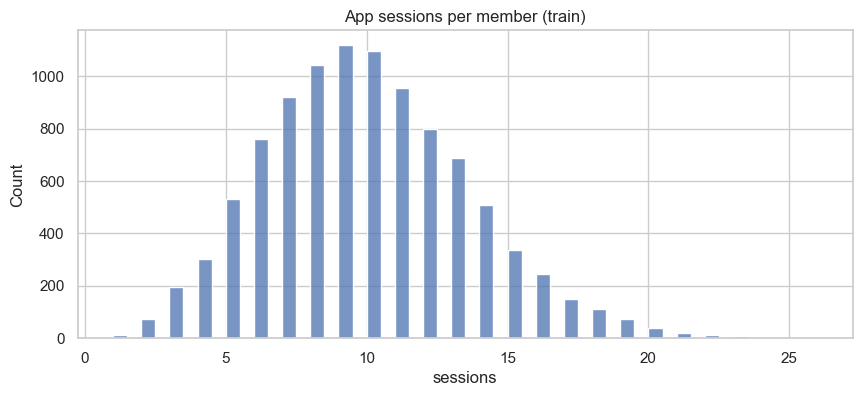

In [74]:
ax = sns.histplot(app_by_member["sessions"], bins=50)
ax.set_title("App sessions per member (train)")
ax.set_xlabel("sessions")
plt.show()



In [75]:
web_by_member = (
    t.web_visits.groupby("member_id")
    .agg(
        visits=("timestamp", "size"),
        last_web_ts=("timestamp", "max"),
        unique_urls=("url", pd.Series.nunique),
        unique_titles=("title", pd.Series.nunique),
    )
    .reset_index()
)

web_by_member[["visits", "unique_urls", "unique_titles"]].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).T



,count,mean,std,min,50%,90%,95%,99%,max
visits,9975.0,25.998997,17.209289,1.0,22.0,49.0,60.0,81.0,140.0
unique_urls,9975.0,25.990476,17.197901,1.0,22.0,49.0,59.3,81.0,140.0
unique_titles,9975.0,13.078596,5.250917,1.0,13.0,20.0,22.0,24.0,26.0


Takeaway: Web visits average ~26 per member with matching unique-URL/title spread, so breadth scales with volume.

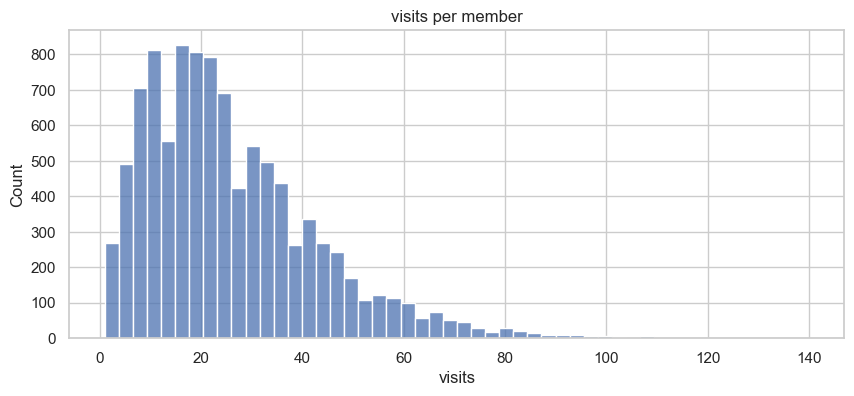

In [78]:
ax = sns.histplot(web_by_member["visits"], bins=50)
ax.set_title("visits per member")
ax.set_xlabel("visits")
plt.show()

Takeaway: Web visits also have a long tail, so log-transforming counts reduces skew.

## 5) Claims (ICD-10)

Claims are sparse for many members but can be high-signal.
Two quick looks:
- Most common ICD codes
- Whether the client’s focus codes (**E11.9**, **I10**, **Z71.3**) show up with meaningful frequency



In [79]:
top_icd = t.claims["icd_code"].value_counts().head(20).to_frame("count")
top_icd



,count
icd_code,
Z71.3,9145
I10,9006
E11.9,8961
H10.9,5414
B34.9,5410
A09,5387
M54.5,5385
J00,5346
R51,5277


Takeaway: The client focus ICDs (Z71.3, I10, E11.9) are among the most frequent, providing strong clinical signal.

In [82]:
FOCUS_CODES = ["E11.9", "I10", "Z71.3"]

claims_member_flags = (
    t.claims.assign(is_focus=t.claims["icd_code"].isin(FOCUS_CODES))
    .groupby("member_id")
    .agg(
        n_claims=("icd_code", "size"),
        n_unique_icd=("icd_code", pd.Series.nunique),
        has_focus_code=("is_focus", "max"),
        last_claim_date=("diagnosis_date", "max"),
    )
    .reset_index()
)

# Break out individual focus codes as separate boolean flags
for code in FOCUS_CODES:
    claims_member_flags[f"has_{code}"] = claims_member_flags["member_id"].isin(
        t.claims.loc[t.claims["icd_code"] == code, "member_id"].unique()
    )

claims_member_flags[["n_claims", "n_unique_icd", "has_focus_code"]].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).T



,count,mean,std,min,50%,90%,95%,99%,max
n_claims,9980.0,6.470541,2.568363,1.0,6.0,10.0,11.0,13.0,18.0
n_unique_icd,9980.0,4.662325,1.550630,1.0,5.0,7.0,7.0,8.0,10.0


Takeaway: Members average ~6.5 claims and ~4.7 unique ICDs, so both frequency and diversity are viable features.

In [83]:
labels_with_claims = labels.merge(claims_member_flags, on="member_id", how="left")

# Members with no claims will have NaNs -> treat as 0 / False
labels_with_claims["n_claims"] = labels_with_claims["n_claims"].fillna(0)
labels_with_claims["n_unique_icd"] = labels_with_claims["n_unique_icd"].fillna(0)
labels_with_claims["has_focus_code"] = labels_with_claims["has_focus_code"].fillna(False)

for code in FOCUS_CODES:
    col = f"has_{code}"
    if col in labels_with_claims.columns:
        labels_with_claims[col] = labels_with_claims[col].fillna(False)

labels_with_claims.groupby("has_focus_code")["churn"].mean().rename("churn_rate")



/var/folders/_f/l3sxbctx63dcs125xrcczr9c0000gn/T/ipykernel_46024/893107940.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_with_claims["has_focus_code"] = labels_with_claims["has_focus_code"].fillna(False)
/var/folders/_f/l3sxbctx63dcs125xrcczr9c0000gn/T/ipykernel_46024/893107940.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_with_claims[col] = labels_with_claims[col].fillna(False)


has_focus_code
False    0.244681
True     0.198638
Name: churn_rate, dtype: float64

Takeaway: Having any focus ICD correlates with slightly lower churn (~19.9% vs ~24.5%), so those flags are worth keeping.

## 6) Web content themes (lightweight keyword scan)

The client brief emphasizes nutrition, movement, sleep, and stress/mindfulness. This is a very rough scan (not NLP), but it helps validate that the web content aligns with the brief and gives us candidate aggregates (e.g., “count of sleep-related page views”).



In [84]:
TOPIC_PATTERNS = {
    "nutrition": r"nutrition|diet|healthy eating|mediterranean|fiber|weight|bmi|cholesterol|lipid",
    "movement": r"movement|exercise|aerobic|strength|cardio|fitness|physical activity",
    "sleep": r"sleep|sleep hygiene|sleep apnea|restorative",
    "stress_mindfulness": r"stress|mindfulness|meditation|resilience|wellbeing|well-being|mental health",
    "diabetes": r"diabetes|glucose|insulin|hba1c|glycemic",
    "blood_pressure": r"hypertension|blood pressure",
}

wv = t.web_visits.copy()
text = (
    wv[["title", "url", "description"]]
    .fillna("")
    .astype("string")
    .agg(" ".join, axis=1)
    .str.lower()
)

for topic, pattern in TOPIC_PATTERNS.items():
    wv[f"is_{topic}"] = text.str.contains(pattern, regex=True)

# Overall prevalence: how many events match each topic?
prevalence = (
    wv[[c for c in wv.columns if c.startswith("is_")]]
    .mean()
    .sort_values(ascending=False)
    .to_frame("share_of_events")
)

(prevalence * 100).round(2)



,share_of_events
is_nutrition,13.10
is_movement,10.82
is_diabetes,6.53
is_stress_mindfulness,6.51
is_sleep,4.38
is_blood_pressure,4.37


Takeaway: Nutrition and movement dominate the topics, followed by diabetes, stress, sleep, and blood pressure, matching the client brief.

In [86]:
topic_cols = [c for c in wv.columns if c.startswith("is_")]

web_topic_by_member = (
    wv.groupby("member_id")
    .agg(
        total_web_events=("timestamp", "size"),
        **{f"n_{c}": (c, "sum") for c in topic_cols},
    )
    .reset_index()
)

web_topic_by_member.head()



,member_id,total_web_events,n_is_nutrition,n_is_movement,n_is_sleep,n_is_stress_mindfulness,n_is_diabetes,n_is_blood_pressure
0,1,3,0,0,0,0,1,1
1,2,9,1,2,1,1,1,2
2,3,52,6,7,4,4,2,3
3,4,15,1,2,2,3,1,0
4,5,11,1,2,2,1,1,0


Takeaway: Member-level topic counts give concrete feature candidates beyond raw visit totals.

In [87]:
labels_with_topics = labels.merge(web_topic_by_member, on="member_id", how="left").fillna(0)

rows = []
for topic in TOPIC_PATTERNS.keys():
    col = f"n_is_{topic}"
    has_any = labels_with_topics[col] > 0
    rows.append(
        {
            "topic": topic,
            "members_with_any": int(has_any.sum()),
            "churn_rate_with_any": float(labels_with_topics.loc[has_any, "churn"].mean()) if has_any.any() else np.nan,
            "churn_rate_with_none": float(labels_with_topics.loc[~has_any, "churn"].mean()) if (~has_any).any() else np.nan,
        }
    )

pd.DataFrame(rows).sort_values("members_with_any", ascending=False)



,topic,members_with_any,churn_rate_with_any,churn_rate_with_none
0,nutrition,8678,0.195782,0.243570
1,movement,8369,0.192377,0.251993
3,stress_mindfulness,7157,0.186531,0.241294
4,diabetes,7077,0.190617,0.229901
5,blood_pressure,5950,0.182857,0.230370
2,sleep,5928,0.189440,0.220530


Takeaway: Exposure to these topics is associated with ~3–5 points lower churn, so topic counts should help ranking prospects.

## Findings (from this EDA run)

### Data volume + duplicates
- `web_visits`: **259,340 rows**, 9,975 members, **0 full-row duplicates**
- `app_usage`: **97,789 rows**, 9,998 members, **0 full-row duplicates**
- `claims`: **64,576 rows**, 9,980 members, **1,676 full-row duplicates**
- `churn_labels`: **10,000 rows**, 10,000 members

### Time ranges
- `web_visits`: **2025-07-01 → 2025-07-14**
- `app_usage`: **2025-07-01 → 2025-07-14**
- `claims`: **2025-07-01 → 2025-07-14**
- `signup_date`: **2024-01-01 → 2025-05-31**

### Labels + outreach
- Churn rate: **20.21%** (train)
- Churn by outreach flag:
  - **No outreach**: 20.74%
  - **Outreach**: 19.40%

(Important: this difference is descriptive only — outreach may be non-random / targeted.)

### Claims: client focus codes show up a lot
Top ICD codes include the client’s focus set:
- **Z71.3**: 9,145
- **I10**: 9,006
- **E11.9**: 8,961

### Web content themes (rough keyword scan)
Share of web events matching each theme:
- **Nutrition**: 13.10%
- **Movement**: 10.82%
- **Diabetes**: 6.53%
- **Stress/mindfulness**: 6.51%
- **Sleep**: 4.38%
- **Blood pressure**: 4.37%



Open questions I’ll keep in mind for later (not solved here):
- How was outreach assigned (random vs targeted)? If targeted, we should treat it as a confounder / selection effect.
- When aggregating features, what exact observation window should be used (same for all members vs relative to signup)?
- Choosing **n**: will depend on cost assumptions + expected lift from outreach (likely needs a simple utility curve).

